# Segmentation of Cells On Microscope Images using UNet

## 0. Imports and install packeges

In [149]:
import os
import shutil
import zipfile
import random
import json

import numpy as np
import skimage
import tifffile

import torch
from torch.utils.data import Dataset
from torchvision.datasets import CocoDetection
from torchvision import datasets, transforms
import torchvision
from torchvision import datasets
import pycocotools.mask as coco_mask

from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import matplotlib.patches as patches


## 1. Get the dataset

### 1.1 Donwload images

In [150]:
!wget http://livecell-dataset.s3.eu-central-1.amazonaws.com/LIVECell_dataset_2021/images.zip

--2024-02-05 23:52:59--  http://livecell-dataset.s3.eu-central-1.amazonaws.com/LIVECell_dataset_2021/images.zip
Resolving livecell-dataset.s3.eu-central-1.amazonaws.com (livecell-dataset.s3.eu-central-1.amazonaws.com)... 3.5.139.117, 3.5.138.106, 52.219.171.122, ...
Connecting to livecell-dataset.s3.eu-central-1.amazonaws.com (livecell-dataset.s3.eu-central-1.amazonaws.com)|3.5.139.117|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1241715651 (1.2G) [application/zip]
Saving to: ‘images.zip.1’

images.zip.1        100%[===================>]   1.16G  74.2MB/s    in 20s     

2024-02-05 23:53:19 (58.2 MB/s) - ‘images.zip.1’ saved [1241715651/1241715651]



In [151]:
dataset_path_zip = '/content/images.zip'
zipfile.ZipFile(dataset_path_zip).extractall('/content/')

In [152]:
# 5% of the train annotations
!wget http://livecell-dataset.s3.eu-central-1.amazonaws.com/LIVECell_dataset_2021/annotations/LIVECell_dataset_size_split/2_train5percent.json

# Validation and Test annotations
!wget http://livecell-dataset.s3.eu-central-1.amazonaws.com/LIVECell_dataset_2021/annotations/LIVECell/livecell_coco_val.json
!wget http://livecell-dataset.s3.eu-central-1.amazonaws.com/LIVECell_dataset_2021/annotations/LIVECell/livecell_coco_test.json

--2024-02-05 23:53:42--  http://livecell-dataset.s3.eu-central-1.amazonaws.com/LIVECell_dataset_2021/annotations/LIVECell_dataset_size_split/2_train5percent.json
Resolving livecell-dataset.s3.eu-central-1.amazonaws.com (livecell-dataset.s3.eu-central-1.amazonaws.com)... 3.5.135.124, 52.219.140.137, 3.5.134.177, ...
Connecting to livecell-dataset.s3.eu-central-1.amazonaws.com (livecell-dataset.s3.eu-central-1.amazonaws.com)|3.5.135.124|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27988522 (27M) [application/json]
Saving to: ‘2_train5percent.json.1’

2_train5percent.jso 100%[===================>]  26.69M  37.7MB/s    in 0.7s    

2024-02-05 23:53:42 (37.7 MB/s) - ‘2_train5percent.json.1’ saved [27988522/27988522]

--2024-02-05 23:53:42--  http://livecell-dataset.s3.eu-central-1.amazonaws.com/LIVECell_dataset_2021/annotations/LIVECell/livecell_coco_val.json
Resolving livecell-dataset.s3.eu-central-1.amazonaws.com (livecell-dataset.s3.eu-central-1.amazonaws.com)

### 1.2 Create custom datasets and Visualizing random images of dataset

In [153]:
class CocoSegmentationDataset(Dataset):
    def __init__(self, root, annFile, transform=None, target_transform=None):
        self.coco_dataset = CocoDetection(root=root, annFile=annFile, transform=transform, target_transform=target_transform)

    def __len__(self):
        return len(self.coco_dataset)

    def __getitem__(self, idx):
        img, ann = self.coco_dataset[idx]
        w, h = img.size
        return img, self.create_mask(w, h, ann)

    def create_mask(self, width, height, ann):
      # Create an empty mask as a numpy array
      mask_np = np.zeros((height, width), dtype=np.uint16)

      # Counter for the object number
      object_number = 1

      # Extract segmentation polygon
      for annotation in ann:
        for seg in annotation['segmentation']:
            if type(seg) is list:
              # Convert polygons to a binary mask and add it to the main mask
              rr, cc = skimage.draw.polygon(seg[1::2], seg[0::2], mask_np.shape)
              mask_np[rr, cc] = object_number
              object_number += 1 #We are assigning each object a unique integer value (labeled mask)

      return mask_np

    def show_random_samples(self, qty: int=5) -> None:
      random_samples = random.sample(range(len(self.coco_dataset)), k=qty)

      fig = plt.figure(figsize=(15, 15))

      for i, sample in enumerate(random_samples):
        fig.add_subplot(1, qty, i+1)
        plt.imshow(self.coco_dataset[sample][0])
        plt.axis('off')

    def show_random_samples_with_annotations_poligons(self, fill_polygons: bool=False) -> None:
      random_samples = random.sample(range(len(self.coco_dataset)), k=4)

      # fig = plt.figure(figsize=(15, 15))
      fig, axs = plt.subplots(2, 2, figsize=(15, 15))

      for idx, ax in enumerate(axs.flat):
        # fig.add_subplot(1, qty, i+1)
        ax.imshow(self.coco_dataset[random_samples[idx]][0])
        ax.axis('off')

        annotations = self.coco_dataset[random_samples[idx]][1]
        for ann in annotations:
          for seg in ann['segmentation']:
            if type(seg) is list:
              poly = [(seg[i], seg[i+1]) for i in range(0, len(seg), 2)]
              polygon = plt.Polygon(poly, closed=True, edgecolor='g', fill=fill_polygons, facecolor='none')
              ax.add_patch(polygon)


In [154]:
# Train, Val and Test images and annotation paths
train_dataset_image_root_path = '/content/images/livecell_train_val_images'
train_dataset_annotations_root_path = '/content/2_train5percent.json'

val_dataset_image_root_path = '/content/images/livecell_train_val_images'
val_dataset_annotations_root_path = '/content/livecell_coco_val.json'

test_dataset_image_root_path = '/content/images/livecell_test_images'
test_dataset_annotations_root_path = '/content/livecell_coco_test.json'

In [155]:
# Train dataset (only 5%)
train_dataset = CocoSegmentationDataset(root=train_dataset_image_root_path, annFile=train_dataset_annotations_root_path);

loading annotations into memory...
Done (t=1.15s)
creating index...
index created!


In [156]:
val_dataset = CocoSegmentationDataset(root=train_dataset_image_root_path, annFile=val_dataset_annotations_root_path)

loading annotations into memory...
Done (t=7.15s)
creating index...
index created!


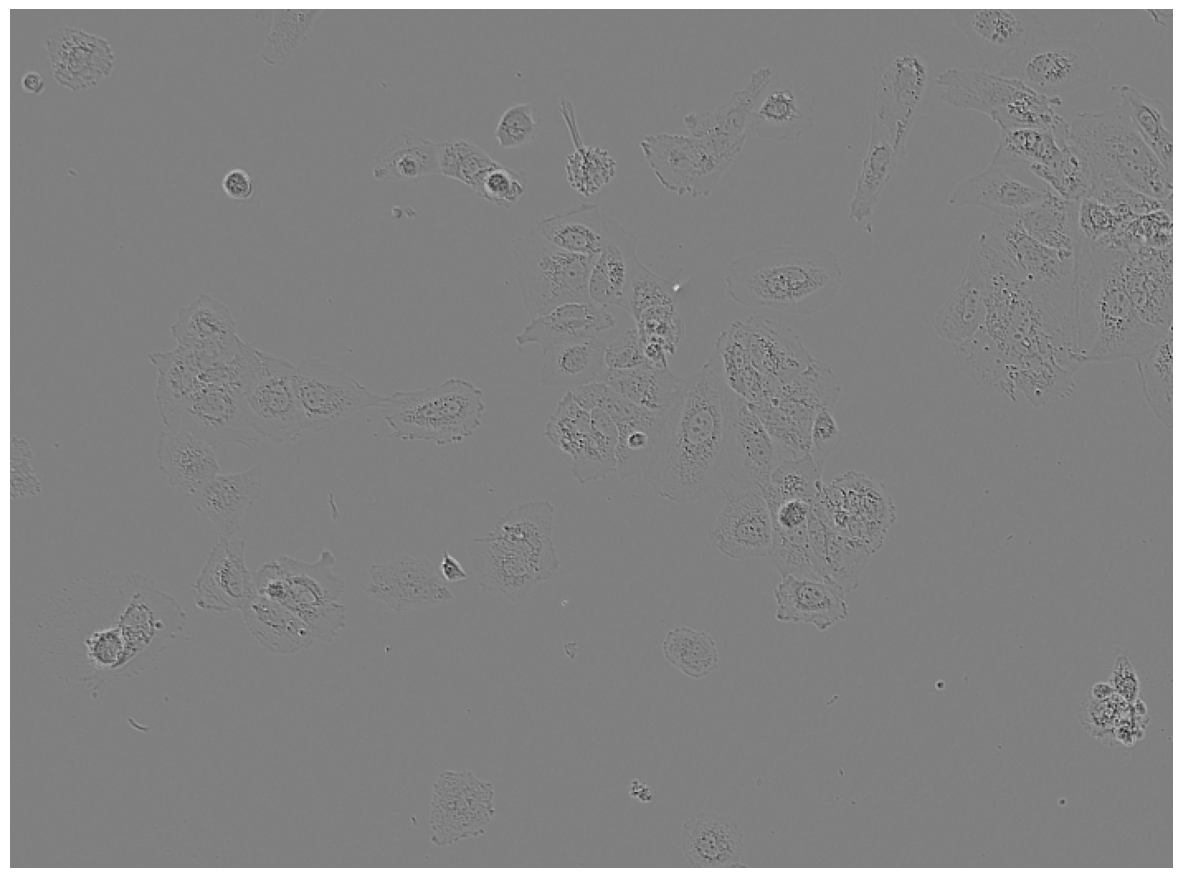

In [157]:
train_dataset.show_random_samples(qty=1)

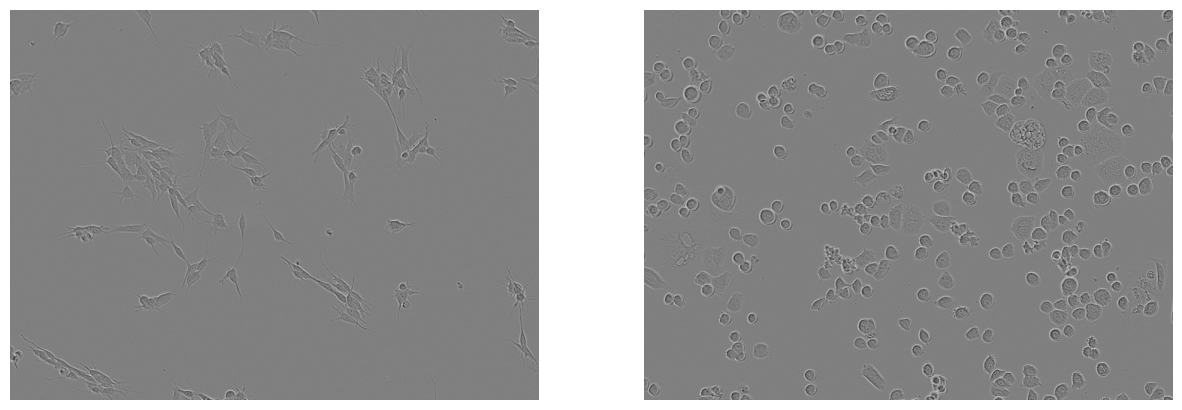

In [158]:
val_dataset.show_random_samples(qty=2)

### 1.3 Visualizing the annotations of a image


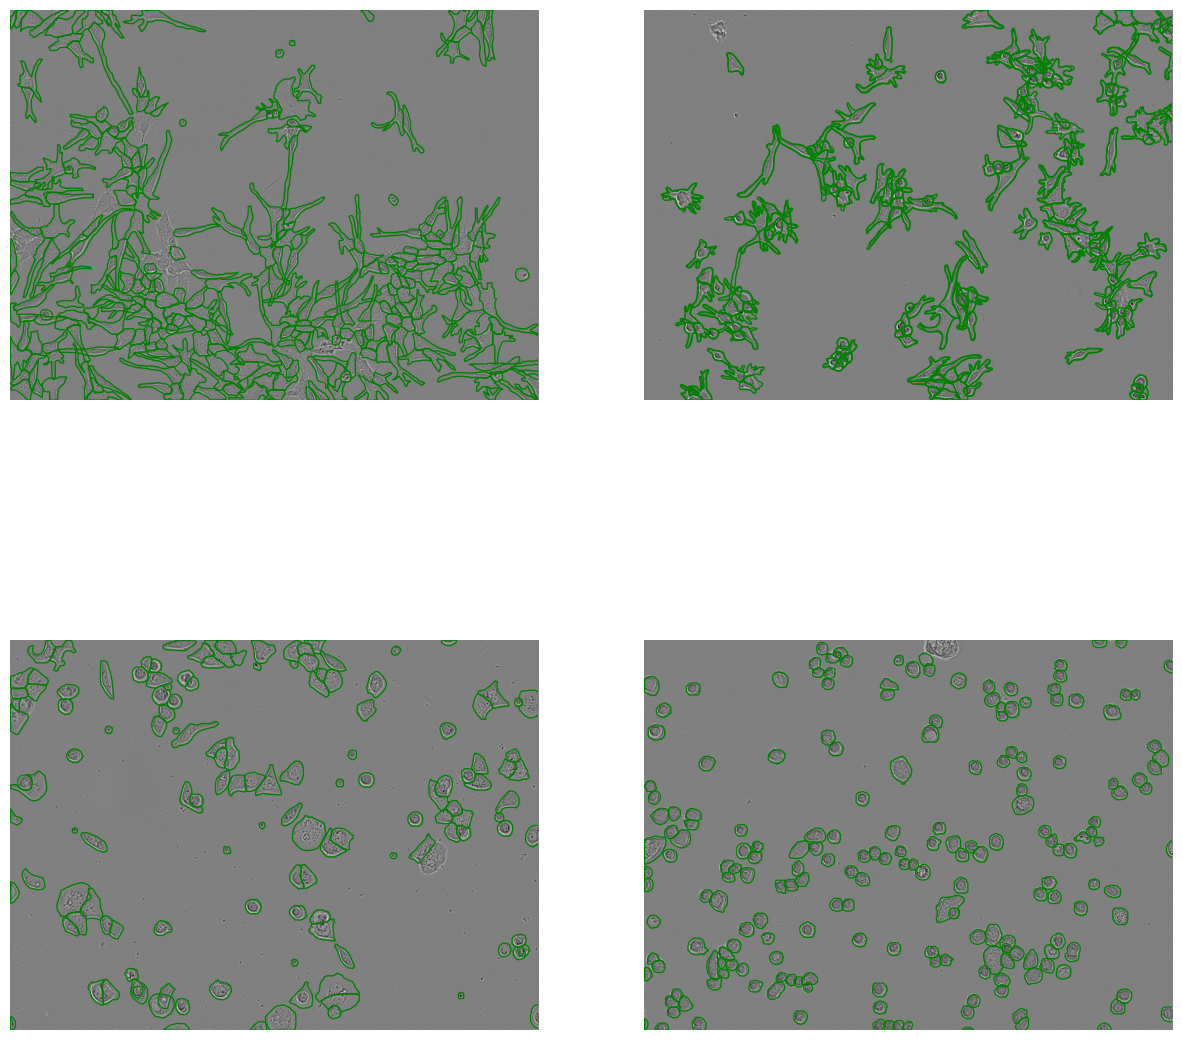

In [159]:
train_dataset.show_random_samples_with_annotations_poligons()

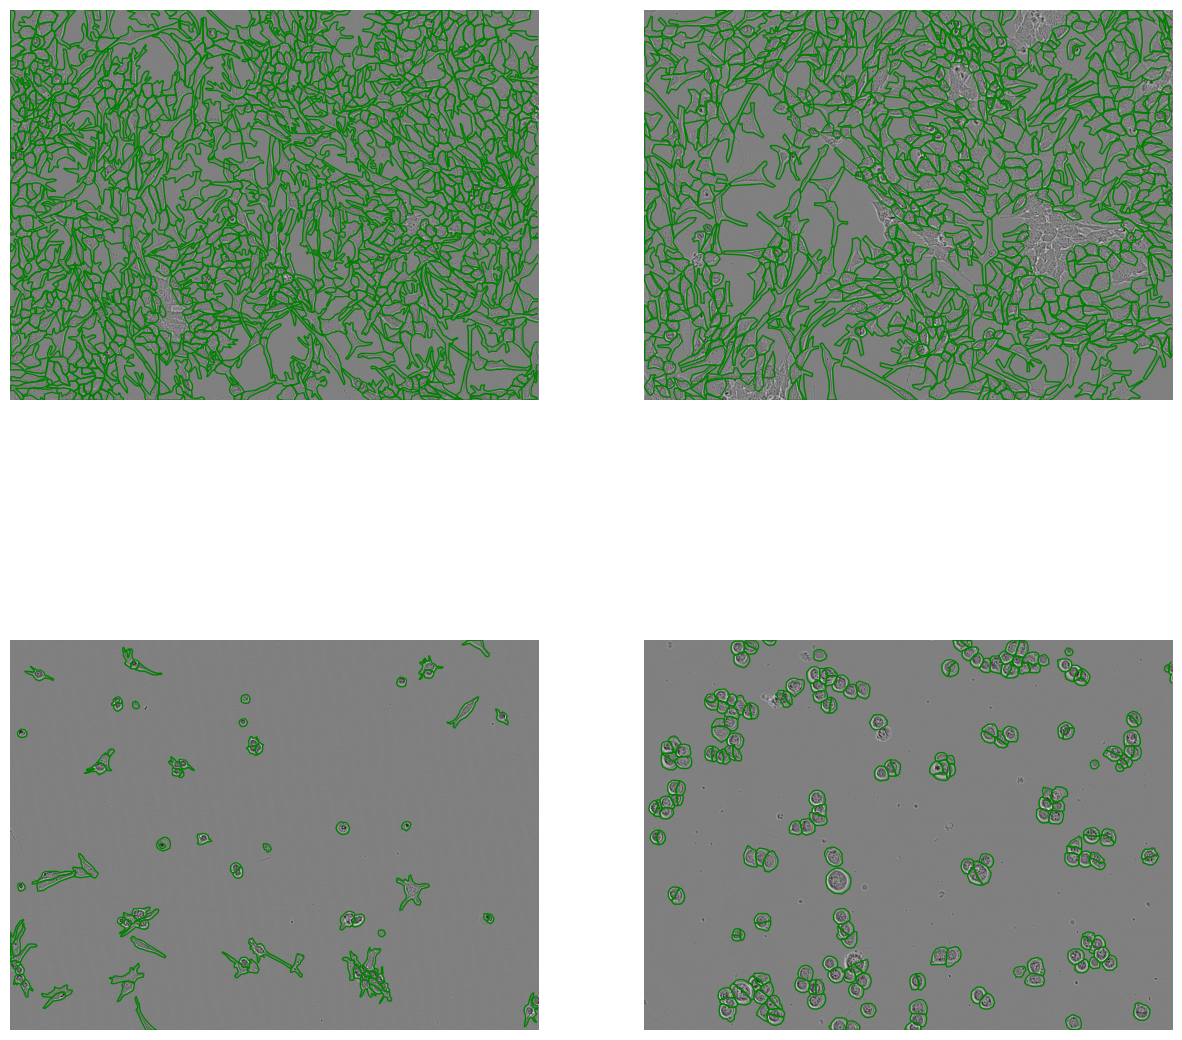

In [160]:
val_dataset.show_random_samples_with_annotations_poligons()

### 1.3 Visualizing the maks segmentation

In [161]:
train_dataset[0]

(<PIL.Image.Image image mode=RGB size=704x520>,
 array([[  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        ...,
        [  0,   0,   0, ..., 122, 122, 122],
        [  0,   0,   0, ..., 122, 122, 122],
        [  0,   0,   0, ..., 122, 122, 122]], dtype=uint16))

In [162]:
def show_random_masks(dataset: datasets.CocoDetection, qty: int=5) -> None:
  random_masks = random.sample(range(len(dataset)), k=qty)

  fig = plt.figure(figsize=(15, 15))

  for i, mask in enumerate(random_masks):
    fig.add_subplot(1, qty, i+1)
    plt.imshow(dataset[mask][1], cmap='gray')
    plt.axis('off')
  plt.show()

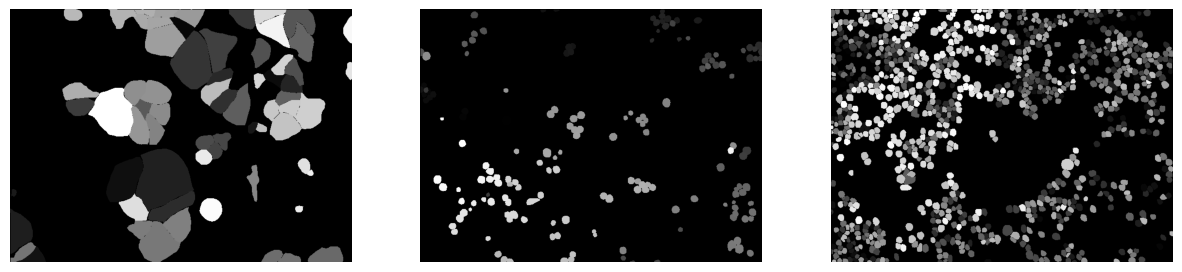

In [163]:
show_random_masks(dataset=train_dataset, qty=3)

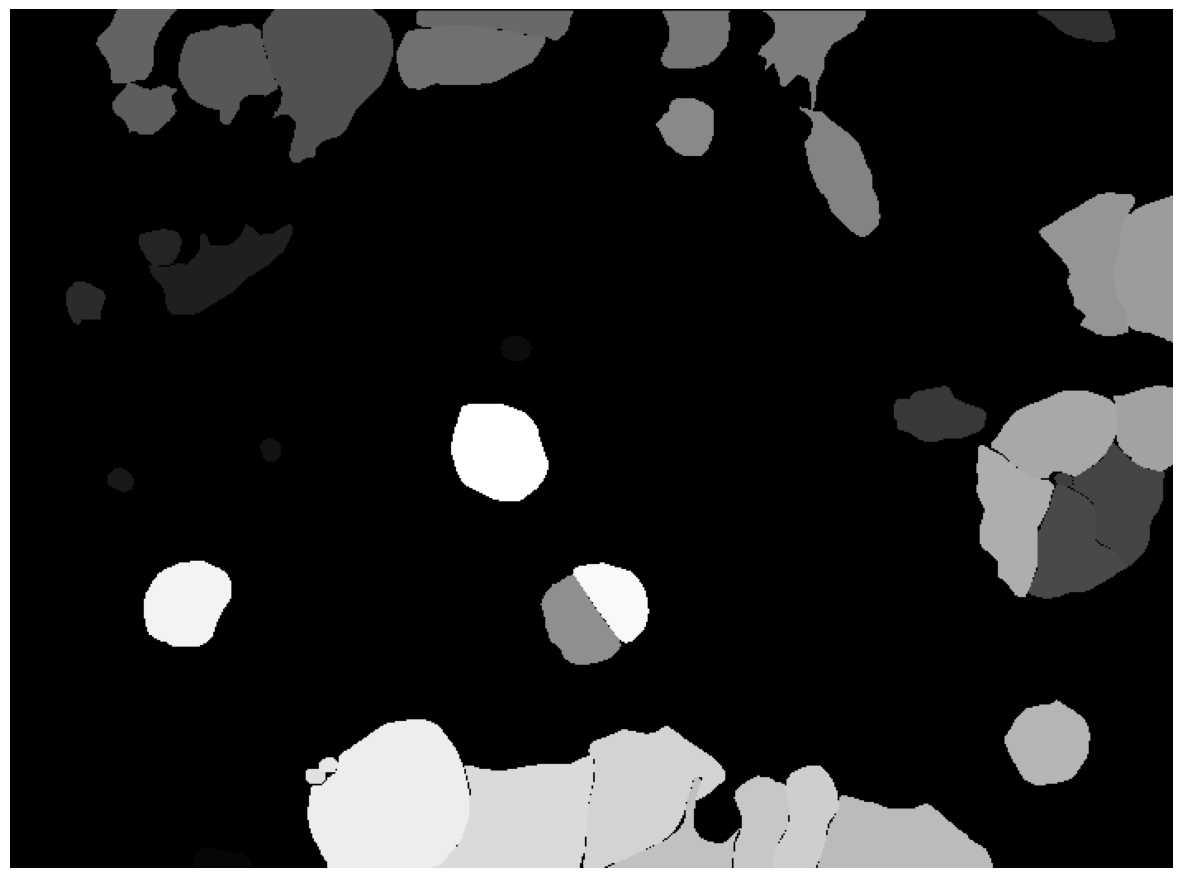

In [164]:
show_random_masks(dataset=val_dataset, qty=1)

### 1.4 Visualizing random images and its respective masks

In [165]:
def show_random_image_and_mask(dataset: datasets.CocoDetection) -> None:
  random_sample = random.choice(range(len(dataset)))

  fig = plt.figure(figsize=(15, 15))

  fig.add_subplot(1, 2, 1)
  plt.imshow(dataset[random_sample][0], cmap='gray')
  plt.title('Original Image')
  plt.axis('off')

  fig.add_subplot(1, 2, 2)
  plt.imshow(dataset[random_sample][1], cmap='gray')
  plt.title('Mask')

  plt.axis('off')
  plt.show()

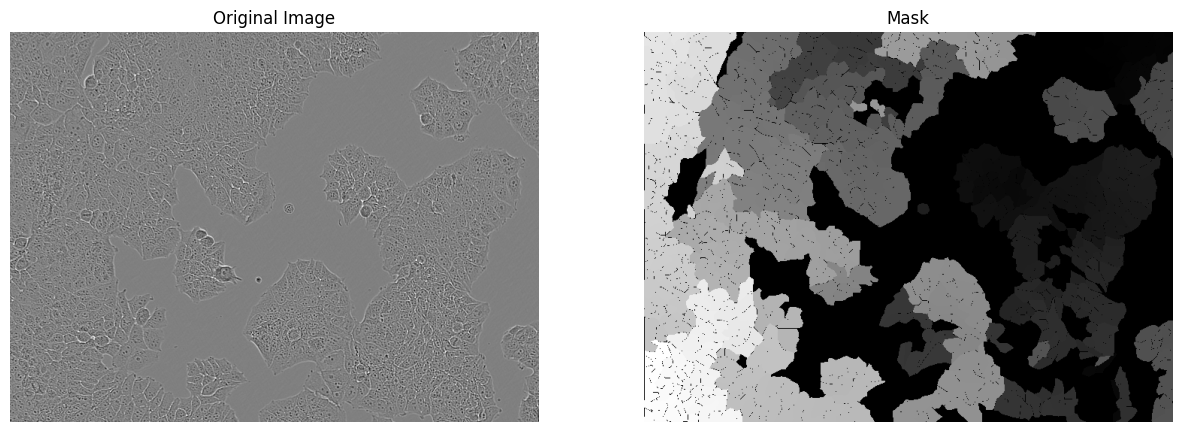

In [166]:
show_random_image_and_mask(train_dataset)

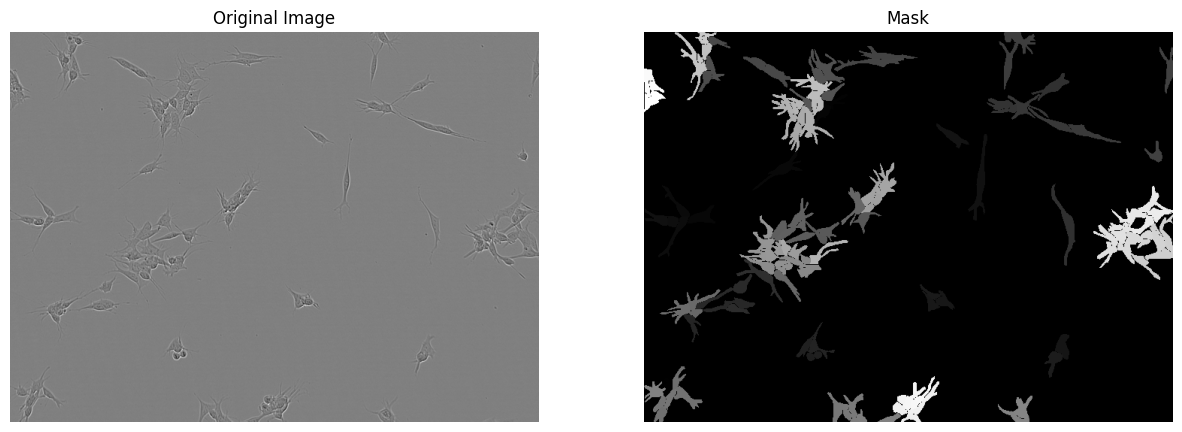

In [167]:
show_random_image_and_mask(val_dataset)

## 2. Build Unet